In [1]:
%load_ext autoreload
%autoreload 2 

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import binary_cross_entropy_with_logits
import urllib.request
import os
import tarfile

from icecream import ic

device = "mps" if torch.backends.mps.is_available() else "cpu"

In [ ]:
# GNN Layer (with separate W for neighbors and B for self)
class GNNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(GNNLayer, self).__init__()
        self.W = nn.Parameter(torch.FloatTensor(in_dim, out_dim))
        self.B = nn.Parameter(torch.FloatTensor(in_dim, out_dim))
        nn.init.xavier_uniform_(self.W)
        nn.init.xavier_uniform_(self.B)

    def forward(self, h, adj_bar):
        # Neighbor aggregation: adj_bar @ h @ W (where adj_bar = D^{-1} A)
        neigh_h = torch.mm(adj_bar, h)
        neigh_h = torch.mm(neigh_h, self.W)
        # Self transformation: h @ B
        self_h = torch.mm(h, self.B)
        # Add them
        return neigh_h + self_h


# GNN Encoder
class GNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(GNNEncoder, self).__init__()
        self.layer1 = GNNLayer(input_dim, hidden_dim)
        self.layer2 = GNNLayer(hidden_dim, hidden_dim)
        self.layer3 = GNNLayer(hidden_dim, embedding_dim)
        self.activation = nn.ReLU()

    def forward(self, x, adj_bar):
        h = self.layer1(x, adj_bar)
        h = self.activation(h)
        h = self.layer2(h, adj_bar)
        h = self.activation(h)
        h = self.layer3(h, adj_bar)  # No activation on last layer for embeddings
        return h


# Cora dataset

https://graphsandnetworks.com/the-cora-dataset/

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

Load cora:

- D_inv is $D_{v,v}=Deg(v) = |N(v)|$, Deg is the nb of neighbours that each node has.
- adj_bar will be reused in $H^{(k+1)}=D^{-1}AH^{(k)}$. We will multiply by H at each layer.
- x: the features (words within doc)

In [28]:
# Load Cora dataset
def load_cora(): ...


# Download and extract if not present
if not os.path.exists("cora"):
    print("Downloading Cora dataset...")
    urllib.request.urlretrieve(
        "https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz", "cora.tgz"
    )
    with tarfile.open("cora.tgz", "r:gz") as tar:
        tar.extractall()

# Load node features and labels
content_path = "cora/cora.content"
content = np.genfromtxt(content_path, dtype=str)
node_ids = content[:, 0].astype(int)
features = content[:, 1:-1].astype(np.float32)
class_strs = content[:, -1]

N = len(node_ids)
node_map = {node_id: i for i, node_id in enumerate(node_ids)}

# Features matrix
X = features  # Already in shape (N, 1433)

# Labels: 7 classes
class_map = {
    "Case_Based": 0,
    "Genetic_Algorithms": 1,
    "Neural_Networks": 2,
    "Probabilistic_Methods": 3,
    "Reinforcement_Learning": 4,
    "Rule_Learning": 5,
    "Theory": 6,
}
labels = np.array([class_map[c] for c in class_strs])

# Load edges (directed citations)
cites_path = "cora/cora.cites"
cites = np.genfromtxt(cites_path, dtype=int)
edges = []
for src, dst in cites:
    if src in node_map and dst in node_map:  # Ensure both exist
        src_idx = node_map[src]
        dst_idx = node_map[dst]
        edges.append([src_idx, dst_idx])

# Adjacency matrix (undirected, no self-loops)
A = np.zeros((N, N), dtype=np.float32)
for u, v in edges:
    A[u, v] = 1.0
    A[v, u] = 1.0  # Make undirected

# see page 50 of 03-GNN1.pdf
#
degrees = np.sum(A, axis=1)
degrees[degrees == 0] = 1.0  # Avoid division by zero
D_inv = np.diag(1.0 / degrees)
adj_bar = D_inv @ A
adj_bar = torch.FloatTensor(adj_bar)
# adj_bar will be used in $$D^{-1}AH^{(k)}$$

x = torch.FloatTensor(X)
pos_edges = np.array(edges)  # Directed for positive samples

# return x, adj_bar, pos_edges, labels, N


# x, adj_bar, pos_edges, labels, N = load_cora()
ic(x.shape, adj_bar.shape, pos_edges.shape, labels.shape, degrees.shape, N);

ic| x.shape: torch.Size([2708, 1433])
    adj_bar.shape: torch.Size([2708, 2708])
    pos_edges.shape: (5429, 2)
    labels.shape: (2708,)
    degrees.shape: (2708,)
    N: 2708


In [ ]:
# Negative sampling (sample non-edges)
def sample_negative_edges(pos_edges, N, num_samples):
    neg_edges = []
    pos_set = set(tuple(e) for e in pos_edges)  # Directed check
    while len(neg_edges) < num_samples:
        u, v = np.random.randint(0, N, 2)
        if u != v and (u, v) not in pos_set:
            neg_edges.append([u, v])
    return np.array(neg_edges)


# Decoder: compute logit (dot product) as similarity measure
def decode(z, edges):
    return torch.sum(z[edges[:, 0]] * z[edges[:, 1]], dim=1)


# Training

# x, adj_bar, pos_edges, labels, N = load_cora()
# data has been loaded above
model = GNNEncoder(input_dim=1433, hidden_dim=32, embedding_dim=16).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_pos = len(pos_edges)
pos_edges_tensor = torch.LongTensor(pos_edges).to(device)
x = x.to(device)
adj_bar = adj_bar.to(device)
# labels = labels.to(device)

for epoch in range(200):
    model.train()
    optimizer.zero_grad()

    z = model(x, adj_bar)

    # Positive logits
    pos_logits = decode(z, pos_edges_tensor)

    # Sample negatives (same number as positives)
    neg_edges = sample_negative_edges(pos_edges, N, num_pos).to(device)
    neg_edges_tensor = torch.LongTensor(neg_edges)
    neg_logits = decode(z, neg_edges_tensor)

    # Labels: 1 for pos, 0 for neg
    pos_labels = torch.ones(num_pos).to(device=device)
    neg_labels = torch.zeros(num_pos).to(device=device)

    # Loss
    loss = binary_cross_entropy_with_logits(
        pos_logits, pos_labels
    ) + binary_cross_entropy_with_logits(neg_logits, neg_labels)

    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# return model, x, adj_bar, labels
ic(model, x, adj_bar, labels);


AttributeError: 'numpy.ndarray' object has no attribute 'to'

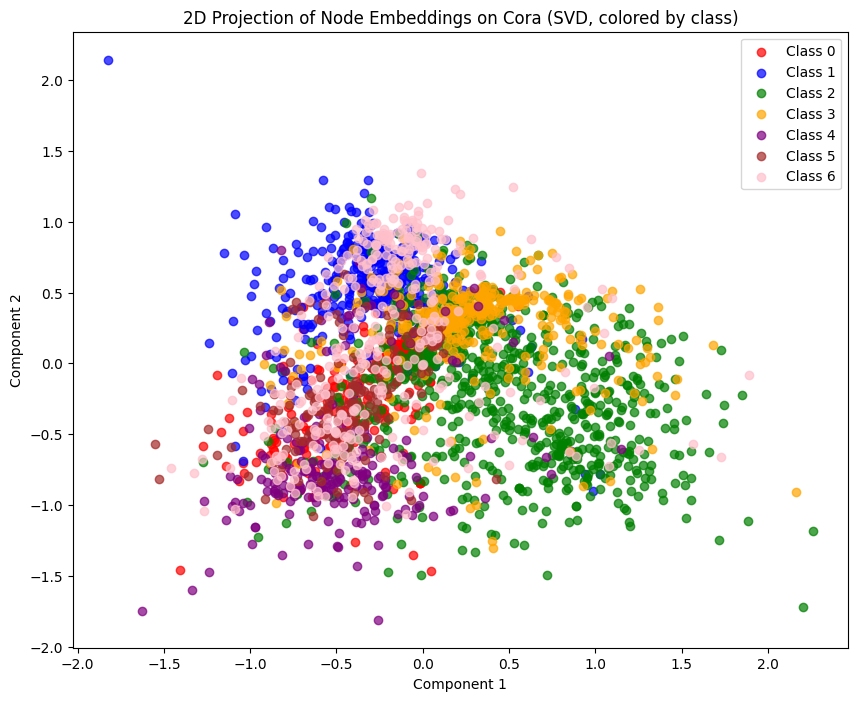

In [32]:
# Inference: Generate embeddings
def inference(model, x, adj_bar):
    model.eval()
    with torch.no_grad():
        z = model(x, adj_bar)
    return z.numpy()


# Visualization: Project to 2D with SVD (manual PCA) and plot (colored by class)
def visualize_embeddings(z, labels):
    # Manual PCA using SVD
    z_mean = np.mean(z, axis=0)
    z_centered = z - z_mean
    U, S, Vt = np.linalg.svd(z_centered, full_matrices=False)
    z_2d = U[:, :2] * S[:2]

    colors = ["red", "blue", "green", "orange", "purple", "brown", "pink"]
    unique_labels = np.unique(labels)

    plt.figure(figsize=(10, 8))
    for i, lbl in enumerate(unique_labels):
        mask = labels == lbl
        plt.scatter(
            z_2d[mask, 0],
            z_2d[mask, 1],
            c=colors[i % len(colors)],
            label=f"Class {lbl}",
            alpha=0.7,
        )
    plt.legend()
    plt.title("2D Projection of Node Embeddings on Cora (SVD, colored by class)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()


# Run everything
if __name__ == "__main__":
    # model, x, adj_bar, labels = train()
    z = inference(model, x, adj_bar)
    visualize_embeddings(z, labels)